In [1]:
import numpy as np
import pandas as pd
import talib
import os
import random
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from matplotlib.dates import AutoDateLocator, DateFormatter

In [2]:
img_path = 'D:/chenxiaoyue/semester4/quant/3y'
images = os.listdir(img_path)
data = []
for i in images:
    data.append(pd.read_csv(os.path.join(img_path, i)))
for i in range(len(data)):
    data[i].index = pd.to_datetime(data[i]['time'])
    data[i] = data[i].drop(['time'], axis = 1)
data[0]

,open,high,low,close,volume,amount
time,,,,,,
2018-01-02 09:30:00,8.75,8.75,8.75,8.75,336,294000
2018-01-02 09:31:00,8.73,8.73,8.70,8.72,592,516454
2018-01-02 09:32:00,8.74,8.75,8.72,8.75,405,353658
2018-01-02 09:33:00,8.74,8.75,8.72,8.72,1127,984772
2018-01-02 09:34:00,8.74,8.79,8.74,8.78,4077,3567578
...,...,...,...,...,...,...
2021-09-16 14:56:00,2.40,2.41,2.40,2.41,886,212710
2021-09-16 14:57:00,2.40,2.41,2.40,2.40,1853,444960
2021-09-16 14:58:00,2.40,2.40,2.40,2.40,22,5280


In [3]:
def resample(data,freq):
    data = data.loc[map(lambda x: x.hour != 9 or x.minute != 30, data.index)]
    new_index = data.index[freq-1 : : freq]
    new_data = pd.DataFrame([], index=new_index, columns=data.columns)
    for i in range(len(data)//freq):
        slice_ = data.iloc[freq*i : freq*(i+1)]
        open_ = slice_['open'][0]
        close_ = slice_['close'][-1]
        high_ = slice_['high'].max()
        low_ = slice_['low'].min()
        volume_ = slice_['volume'].sum()
        amount_ = slice_['amount'].sum()
        new_data.iloc[i] = [open_, high_, low_, close_, volume_, amount_]
    new_data['ret'] = new_data['close'] / new_data['open'] - 1
    return new_data


### In order to avoid excessive calculations, we randomly select 100 stocks and reduce the data to 30min to 30 minutes

In [5]:
a = [i for i in range(500)]
rand_list = random.sample(a,100)

In [6]:
resampled_data =  []
for i in range(len(rand_list)):
    resampled_data.append(resample(data[rand_list[i]], 30))

In [209]:
resampled_data[0].index

DatetimeIndex(['2018-01-02 10:00:00', '2018-01-02 10:30:00',
               '2018-01-02 11:00:00', '2018-01-02 11:30:00',
               '2018-01-02 13:30:00', '2018-01-02 14:00:00',
               '2018-01-02 14:30:00', '2018-01-02 15:00:00',
               '2018-01-03 10:00:00', '2018-01-03 10:30:00',
               ...
               '2021-09-15 14:30:00', '2021-09-15 15:00:00',
               '2021-09-16 10:00:00', '2021-09-16 10:30:00',
               '2021-09-16 11:00:00', '2021-09-16 11:30:00',
               '2021-09-16 13:30:00', '2021-09-16 14:00:00',
               '2021-09-16 14:30:00', '2021-09-16 15:00:00'],
              dtype='datetime64[ns]', name='time', length=7232, freq=None)

### Next calculate various factors exposure
#### feature1
We first consider converting the four -valent strategy of Philians in the first homework into factor. Convert the -1/1 signal to a continuous number through some calculations as factor. Note that the frequency of warehouse changes is changed from 10 minutes to 30 minutes to calculate IC.

。
$$
\alpha_{t,now} = \frac{2openprice_{t,now} - high_{t-1} - low_{t-1}}{high_{t-1}-low_{t-1}}
$$


#### Let's calculate the factor exposure at these points in time. If the data is missing at a certain point in time, it is recorded as Nan

In [1]:
# Philip Ali Four Valent
def falsj(stock):
    alpha = pd.Series(np.nan, index=stock.index)  # Record the factor exposure of individual stocks on the trading day.

    for di in range(1, stock.shape[0]): 
        last_high = stock['high'].iloc[di - 1]
        last_low = stock['low'].iloc[di - 1]
        if last_high == last_low:
            continue
        else:
            exposure = (2*stock['open'].iloc[di]-last_high -
                        last_low)/(last_high-last_low)
            alpha.iloc[di] = exposure

    return alpha


In [9]:
falsj(resampled_data[0])

time
2018-01-02 10:00:00         NaN
2018-01-02 10:30:00   -0.777778
2018-01-02 11:00:00   -0.600000
2018-01-02 11:30:00   -0.600000
2018-01-02 13:30:00    0.142857
                         ...   
2021-09-16 11:30:00   -1.000000
2021-09-16 13:30:00    0.333333
2021-09-16 14:00:00   -1.000000
2021-09-16 14:30:00    0.000000
2021-09-16 15:00:00    1.000000
Length: 7232, dtype: float64

#### feature2 
Considering a price factor, general retail investors believe that the stock price volume is rising as a good, and we do their reverse factor.

$$
\alpha_t = -(\frac{closeprice_{t}}{closeprice_{t-delay}}-1)\times \frac{volume_t}{volume_{t-delay}} \\
delay = 1
$$

In [10]:
# 价量策略
def pv(stock):
    alpha = pd.Series(np.nan, index=stock.index)  # Record the factor exposure of individual stocks on the trading day.
    for di in range(1, stock.shape[0]):  
        if stock['volume'][di - 1] == 0:
            continue
        exposure = -(stock['close'][di]/stock['close'][di-1]-1) * \
            (stock['volume'][di]/stock['volume'][di-1])
        alpha.iloc[di] = exposure
    return alpha


In [11]:
pv(resampled_data[0])

time
2018-01-02 10:00:00         NaN
2018-01-02 10:30:00   -0.001830
2018-01-02 11:00:00    0.003900
2018-01-02 11:30:00   -0.000000
2018-01-02 13:30:00    0.005154
                         ...   
2021-09-16 11:30:00   -0.000000
2021-09-16 13:30:00    0.003420
2021-09-16 14:00:00   -0.000000
2021-09-16 14:30:00   -0.000000
2021-09-16 15:00:00    0.011662
Length: 7232, dtype: float64

#### feature3
Consider another reversal factor$$
\alpha_t = 1-\frac{closeprice_{t}}{closeprice_{t-delay}} \\
delay = 5
$$

In [12]:
# 反转因子
def reverse(stock):
    alpha = pd.Series(np.nan, index=stock.index)  # Record the factor exposure of individual stocks on the trading day.
    for di in range(5, stock.shape[0]): 
        if stock['close'][di-5] == 0:
            continue
        exposure = 1-stock['close'][di]/stock['close'][di-5]
        alpha.iloc[di] = exposure
    return alpha


In [13]:
reverse(resampled_data[0])

time
2018-01-02 10:00:00         NaN
2018-01-02 10:30:00         NaN
2018-01-02 11:00:00         NaN
2018-01-02 11:30:00         NaN
2018-01-02 13:30:00         NaN
                         ...   
2021-09-16 11:30:00    0.000000
2021-09-16 13:30:00    0.005952
2021-09-16 14:00:00    0.029070
2021-09-16 14:30:00    0.017647
2021-09-16 15:00:00    0.011905
Length: 7232, dtype: float64

Next we choose some of the factors in Alpha101

In [14]:
def rank(df):
    return df.rank(pct=True, axis=1)

def stddev(df,window=10):
    return df.rolling(window).std()
    
def ts_argmax(df,window=10):
    return df.rolling(window).apply(np.argmax) + 1

def correlation(x,y,window=10):
    return x.rolling(window).corr(y)

def delta(df,period=1):
    return df.diff(period)

def ts_sum(df, window=10):
    return df.rolling(window).sum()

def ts_min(df, window=10):
    return df.rolling(window).min()

def ts_max(df, window=10):
    return df.rolling(window).max()

def delay(df,period=1):
    return df.shift(period)

In [15]:
class Alpha101(object):
    def __init__(self, df_data):
        self.price_df = df_data.copy()
        self.open = self.price_df['open'].rename(columns={'open':'v'})
        self.high = self.price_df['high'].rename(columns={'high':'v'})
        self.low = self.price_df['low'].rename(columns={'low':'v'})
        self.close = self.price_df['close'].rename(columns={'close':'v'})
        self.volume= self.price_df['volume'].rename(columns={'volume':'v'})
        self.returns = self.price_df['ret'].rename(columns={'ret':'v'})
    
    def alpha001(self, k):
        inner = self.close
        inner[self.returns < 0] = stddev(self.returns, 20)
        return rank(ts_argmax(inner ** 2, 5)).iloc[:, k - 1] - 0.5
    
    def alpha002(self, k):
        df = -1 * correlation(rank(delta(self.volume.applymap(lambda v: np.log(v+10**-5) if isinstance(v, float) else v),2)).iloc[:, k - 1], 
                              rank((self.close - self.open) / self.open).iloc[:, k - 1]
                              , 6)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
    
    def alpha006(self, k):
        df = -1 * correlation(self.open.iloc[:, k - 1], self.volume.iloc[:, k - 1], 10)
        return df.replace([-np.inf, np.inf], 0).fillna(value=0)
    
    def alpha008(self, k):
        return -1 * (rank(((ts_sum(self.open,5) * ts_sum(self.returns,5)) - delay((ts_sum(self.open,5) * ts_sum(self.returns,5)), 10)))
                    .iloc[:, k - 1])
    
    def alpha009(self, k):
        delta_close = delta(self.close,1)
        cond_1 = ts_min(delta_close, 5) > 0
        cond_2 = ts_max(delta_close, 5) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return alpha.iloc[:, k - 1]
    
    def alpha010(self, k):
        delta_close = delta(self.close,1)
        cond_1 = ts_min(delta_close, 4) > 0
        cond_2 = ts_max(delta_close, 4) < 0
        alpha = -1 * delta_close
        alpha[cond_1 | cond_2] = delta_close
        return rank(alpha).iloc[:, k - 1]    
    
    def alpha019(self, k):
        return  ((-1 * np.sign(pd.DataFrame((self.close - delay(self.close, 7)) + delta(self.close, 7), dtype = np.float64))) * (1+rank(1+ts_sum(self.returns, 250)))).iloc[:, k-1]
    
    def alpha020(self, k):
        return -1 * (rank(self.open - delay(self.high, 1)) * rank(self.open - delay(self.close, 1)) * rank(self.open - delay(self.low, 1))).iloc[:,k-1]
    
    def alpha022(self, k):
        df = correlation(self.high.iloc[:,k-1], self.volume.iloc[:,k-1], 5)
        df = df.replace([-np.inf, np.inf], 0).fillna(value = 0)
        return -1 * delta(df, 5) * rank(stddev(self.close, 20)).iloc[:,k-1]
    
    def alpha101(self, k):
        return ((self.close - self.open) / (self.high - self.close + 0.001)).iloc[:,k-1]

In [16]:
df1 = pd.DataFrame()
for i in range(len(resampled_data)):
    df1 = pd.concat([df1,resampled_data[i]],axis=1)

In [17]:
df1

,open,high,low,close,volume,amount,ret,open,high,low,...,volume,amount,ret,open,high,low,close,volume,amount,ret
time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 10:00:00,5.53,5.57,5.48,5.48,11545,6347315,-0.009042,9.81,9.88,9.73,...,NaN,NaN,NaN,2.61,2.64,2.59,2.64,126143,32941658,0.011494
2018-01-02 10:30:00,5.49,5.5,5.45,5.49,11577,6335168,0.0,9.85,9.95,9.82,...,NaN,NaN,NaN,2.64,2.74,2.64,2.7,273365,73561773,0.022727
2018-01-02 11:00:00,5.46,5.51,5.46,5.47,12395,6790006,0.001832,9.91,10.0,9.89,...,NaN,NaN,NaN,2.7,2.7,2.68,2.7,46830,12602578,0.0
2018-01-02 11:30:00,5.47,5.5,5.43,5.47,20785,11347147,0.0,9.9,9.94,9.86,...,NaN,NaN,NaN,2.7,2.71,2.69,2.71,45838,12387456,0.003704
2018-01-02 13:30:00,5.47,5.47,5.43,5.43,14650,7966831,-0.007313,9.92,9.93,9.89,...,NaN,NaN,NaN,2.71,2.71,2.68,2.69,57202,15417437,-0.00738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16 11:30:00,1.68,1.7,1.67,1.68,125421,21109207,0.0,7.5,7.54,7.46,...,3323,28697663,-0.003925,2.9,2.9,2.86,2.88,146156,42102931,-0.006897
2021-09-16 13:30:00,1.69,1.69,1.67,1.67,72056,12083430,-0.011834,7.48,7.52,7.44,...,7584,65745234,0.011473,2.88,2.88,2.85,2.87,122955,35227657,-0.003472
2021-09-16 14:00:00,1.67,1.68,1.66,1.67,100712,16804492,0.0,7.51,7.51,7.33,...,6119,53008726,-0.009166,2.86,2.87,2.85,2.86,116830,33381077,0.0


In [20]:
for i in range(len(resampled_data)):
    resampled_data[i]['alpha1'] = falsj(resampled_data[i])
    resampled_data[i]['alpha2'] = pv(resampled_data[i])
    resampled_data[i]['alpha3'] = reverse(resampled_data[i])
    resampled_data[i]['alpha4'] = a.alpha002(i + 1)
    resampled_data[i]['alpha5'] = a.alpha006(i + 1)
    resampled_data[i]['alpha6'] = a.alpha008(i + 1)
    resampled_data[i]['alpha7'] = a.alpha009(i + 1)
    resampled_data[i]['alpha8'] = a.alpha010(i + 1)
    resampled_data[i]['alpha9'] = a.alpha019(i + 1)
    resampled_data[i]['alpha10'] = a.alpha020(i + 1)
    resampled_data[i]['alpha11'] = a.alpha022(i + 1)
    resampled_data[i]['alpha12'] = a.alpha101(i + 1)
resampled_data[0]

,open,high,low,close,volume,amount,ret,alpha1,alpha2,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,alpha12
time,,,,,,,,,,,,,,,,,,,
2018-01-02 10:00:00,5.53,5.57,5.48,5.48,11545,6347315,-0.009042,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,-0.549451
2018-01-02 10:30:00,5.49,5.5,5.45,5.49,11577,6335168,0.0,-0.777778,-0.001830,NaN,0.000000,0.000000,NaN,-0.01,0.548913,NaN,-0.016397,NaN,0.0
2018-01-02 11:00:00,5.46,5.51,5.46,5.47,12395,6790006,0.001832,-0.600000,0.003900,NaN,0.000000,0.000000,NaN,0.02,0.815217,NaN,-0.000387,NaN,0.243902
2018-01-02 11:30:00,5.47,5.5,5.43,5.47,20785,11347147,0.0,-0.600000,-0.000000,NaN,0.000000,0.000000,NaN,-0.0,0.663043,NaN,-0.031115,NaN,0.0
2018-01-02 13:30:00,5.47,5.47,5.43,5.43,14650,7966831,-0.007313,0.142857,0.005154,NaN,0.000000,0.000000,NaN,0.04,0.853261,NaN,-0.092322,NaN,-0.97561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16 11:30:00,1.68,1.7,1.67,1.68,125421,21109207,0.0,-1.000000,-0.000000,0.000000,-0.598773,-0.306490,-0.44,-0.0,0.360000,-0.00,-0.021240,-0.011165,0.0
2021-09-16 13:30:00,1.69,1.69,1.67,1.67,72056,12083430,-0.011834,0.333333,0.003420,0.005952,-0.731748,-0.211975,-0.55,0.01,0.630000,1.76,-0.307803,-0.021023,-0.952381
2021-09-16 14:00:00,1.67,1.68,1.66,1.67,100712,16804492,0.0,-1.000000,-0.000000,0.029070,-0.537410,-0.205768,-0.80,-0.0,0.370000,1.76,-0.024720,0.008366,0.0


In [21]:
df2 = pd.DataFrame()
for i in range(len(resampled_data)):
    df2 = pd.concat([df2,resampled_data[i]],axis=1)

In [22]:
df2

,open,high,low,close,volume,amount,ret,alpha1,alpha2,alpha3,...,alpha3,alpha4,alpha5,alpha6,alpha7,alpha8,alpha9,alpha10,alpha11,alpha12
time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 10:00:00,5.53,5.57,5.48,5.48,11545,6347315,-0.009042,NaN,NaN,NaN,...,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,30.0
2018-01-02 10:30:00,5.49,5.5,5.45,5.49,11577,6335168,0.0,-0.777778,-0.001830,NaN,...,NaN,0.000000,0.000000,NaN,-0.06,0.320652,NaN,-0.169728,NaN,1.463415
2018-01-02 11:00:00,5.46,5.51,5.46,5.47,12395,6790006,0.001832,-0.600000,0.003900,NaN,...,NaN,0.000000,0.000000,NaN,-0.0,0.554348,NaN,-0.089979,NaN,0.0
2018-01-02 11:30:00,5.47,5.5,5.43,5.47,20785,11347147,0.0,-0.600000,-0.000000,NaN,...,NaN,0.000000,0.000000,NaN,-0.01,0.500000,NaN,-0.153383,NaN,10.0
2018-01-02 13:30:00,5.47,5.47,5.43,5.43,14650,7966831,-0.007313,0.142857,0.005154,NaN,...,NaN,0.000000,0.000000,NaN,0.02,0.755435,NaN,-0.106880,NaN,-0.952381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16 11:30:00,1.68,1.7,1.67,1.68,125421,21109207,0.0,-1.000000,-0.000000,0.000000,...,-0.014085,-0.445442,0.069463,-0.58,0.01,0.450000,-1.76,-0.278045,-0.055428,-0.952381
2021-09-16 13:30:00,1.69,1.69,1.67,1.67,72056,12083430,-0.011834,0.333333,0.003420,0.005952,...,-0.003497,-0.931739,0.153174,-0.66,0.01,0.630000,-1.77,-0.183483,-0.088479,-0.909091
2021-09-16 14:00:00,1.67,1.68,1.66,1.67,100712,16804492,0.0,-1.000000,-0.000000,0.029070,...,0.023891,-0.724043,0.076927,-0.82,0.01,0.315000,-1.77,-0.016560,-0.006755,0.0


Merge all Alpha in the same form

In [23]:
from scipy.stats.mstats import winsorize
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

alpha_set = []
for i in range(12):
    which = 'alpha' + str(i + 1)
    alpha = df2[which]
    normalized_alpha = alpha.apply(lambda x: pd.Series(preprocessing.scale(winsorize(x,limits=[0.025, 0.025]))), axis =1)
    alpha_set.append(normalized_alpha)
alpha_set[0]

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:30:00,-1.564331,0.797222,0.340147,0.503388,-1.417833,-0.852222,0.993111,-1.396737,0.993111,-1.754779,...,0.797222,0.703730,0.013665,0.111610,-1.564331,1.319593,-0.901904,0.829870,NaN,1.482834
2018-01-02 11:00:00,-1.600689,0.132044,0.041798,-1.563641,0.335099,1.009976,-0.544805,-0.447038,0.041798,0.432866,...,0.712200,0.937138,1.215002,-1.131407,0.209398,0.963601,0.628400,1.215002,NaN,-0.192843
2018-01-02 11:30:00,-1.252801,-1.634643,-1.952844,-0.086064,-0.202738,0.344170,1.547368,1.450140,0.672315,-1.119460,...,0.672315,-1.335159,0.147283,-0.202738,0.547308,-1.952844,-1.515317,0.380631,NaN,1.547368
2018-01-02 13:30:00,-0.037772,0.587367,1.462562,-0.537884,0.295635,1.121023,0.587367,-1.581595,0.587367,-0.944224,...,1.462562,-0.987984,-1.163023,-0.287828,-0.037772,1.462562,0.684611,0.149769,NaN,1.462562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16 11:30:00,-1.370382,-0.391336,-1.370382,-0.332000,-0.146575,1.439842,-0.925361,0.869622,1.349190,-1.370382,...,0.261361,-1.186811,0.727573,-0.993826,-0.671063,-0.434529,-0.758478,-0.880859,2.013568,0.587710
2021-09-16 13:30:00,1.311393,-0.282850,2.586787,-1.239396,-0.091541,1.749810,-0.389133,-0.313498,-0.856778,-0.665468,...,0.923229,0.455057,-1.007506,0.035998,-0.282850,-1.167204,-0.339118,0.400397,-0.021974,0.673696
2021-09-16 14:00:00,-1.572304,1.512590,-1.572304,-0.439077,-0.397106,-0.120589,0.190493,1.953289,0.778091,1.248170,...,-0.029857,0.011658,0.316407,-1.068648,0.190493,-0.564992,-0.931287,-0.397106,1.522383,-0.397106


Next, calculate the IC, ICIR, and layered recovery of each factor to select the appropriate factors.

In [24]:
def get_IC(k, way):
    f_ret = df2['ret'].shift(-1)
    alpha = alpha_set[k - 1]
    IC = []
    for i in range(df2.shape[0]):
        s1 = alpha.iloc[i].values
        s2 = f_ret.iloc[i].values
        x = pd.DataFrame([s1, s2]).T.corr(method = way)[0][1]
        IC.append(x)
    ICSeries = pd.Series(IC, index = df2.index)
    return ICSeries

IC of alpha1 count    7230.000000
mean       -0.016794
std         0.117581
min        -0.490340
25%        -0.096468
50%        -0.016140
75%         0.062268
max         0.435178
dtype: float64
IC of alpha2 count    7230.000000
mean        0.067786
std         0.140792
min        -0.475094
25%        -0.027065
50%         0.070889
75%         0.164410
max         0.537528
dtype: float64
IC of alpha3 count    7226.000000
mean        0.055505
std         0.150950
min        -0.481423
25%        -0.044068
50%         0.056257
75%         0.157979
max         0.602684
dtype: float64
IC of alpha4 count    7224.000000
mean        0.009024
std         0.108676
min        -0.407319
25%        -0.064443
50%         0.009068
75%         0.083726
max         0.384772
dtype: float64
IC of alpha5 count    7222.000000
mean        0.010946
std         0.119466
min        -0.602922
25%        -0.067314
50%         0.011976
75%         0.090190
max         0.418440
dtype: float64
IC of alpha6 count  

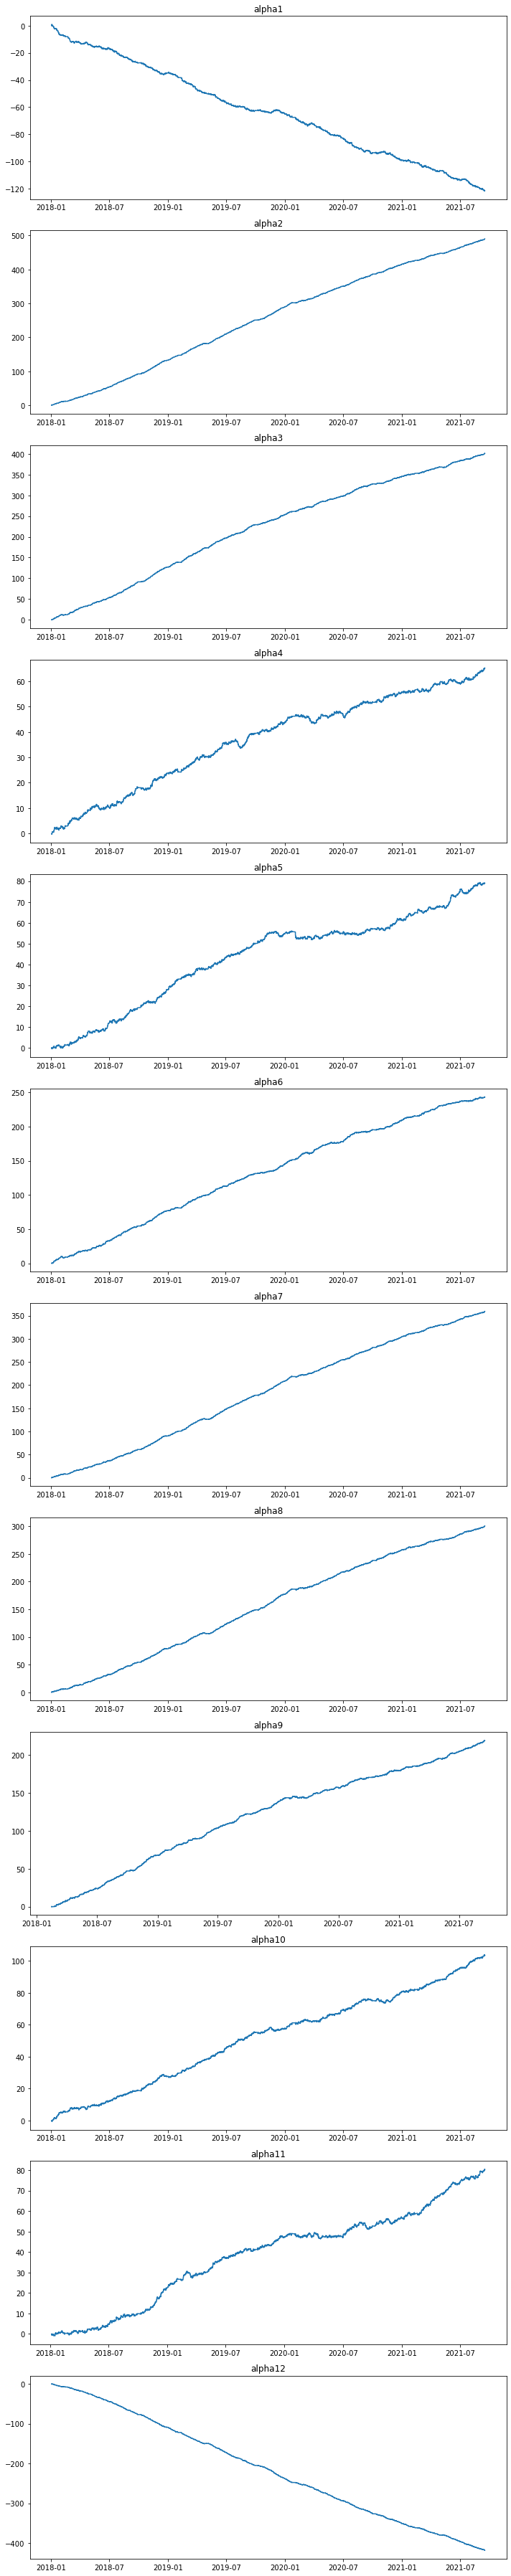

In [25]:
IC=[]
fig, ax = plt.subplots(12, 1, figsize = (10,50))
for i in range(12):
    IC.append(get_IC(i + 1, 'spearman'))
    print('IC of alpha'+str(i + 1), IC[i].describe())
    ax[i].plot(IC[i].cumsum())
    ax[i].set_title('alpha' + str(i + 1))
    plt.tight_layout()

In [26]:
ICIR=[]
for i in range(12):
    ICIR.append(get_IC(i + 1, 'spearman').mean() / get_IC(i + 1, 'spearman').std())
    print('ICIR of alpha'+str(i + 1), ICIR[i])

ICIR of alpha1 -0.1428324194506951
ICIR of alpha2 0.48145758539059763
ICIR of alpha3 0.3677032090938146
ICIR of alpha4 0.08303819172503621
ICIR of alpha5 0.09162286510708557
ICIR of alpha6 0.2404217801278108
ICIR of alpha7 0.34988705999063774
ICIR of alpha8 0.30182153814106877
ICIR of alpha9 0.2247017957801794
ICIR of alpha10 0.1203951551865327
ICIR of alpha11 0.08645859968365867
ICIR of alpha12 -0.44846523852240233


Due to the normalization of the factors, there is no need to use a linear regression calculation factor income here.

We choose the Alpha factor greater than equal to 0.03 and IR greater than or equal to 0.3, that is, the above Alpha2, 3, 7,8,12 and make a layered test test single factor predictive effect. Among them, Alpha12 needs to be countered.

alpha2 最大回撤： -0.15952020562568292
alpha2 年化收益率 0.45638895517832245
alpha2 Sharpe ratio 2.1252607489570075
alpha3 最大回撤： -0.1754951882822442
alpha3 年化收益率 0.4014897136354949
alpha3 Sharpe ratio 1.7210020082261663
alpha7 最大回撤： -0.1791572036449688
alpha7 年化收益率 0.40116233825478087
alpha7 Sharpe ratio 1.7372933522169616
alpha8 最大回撤： -0.21349773175825348
alpha8 年化收益率 0.3682783010400619
alpha8 Sharpe ratio 1.6201096100595564
alpha12 最大回撤： -0.2609283231158106
alpha12 年化收益率 0.12354056221184817
alpha12 Sharpe ratio 0.6242690914822387


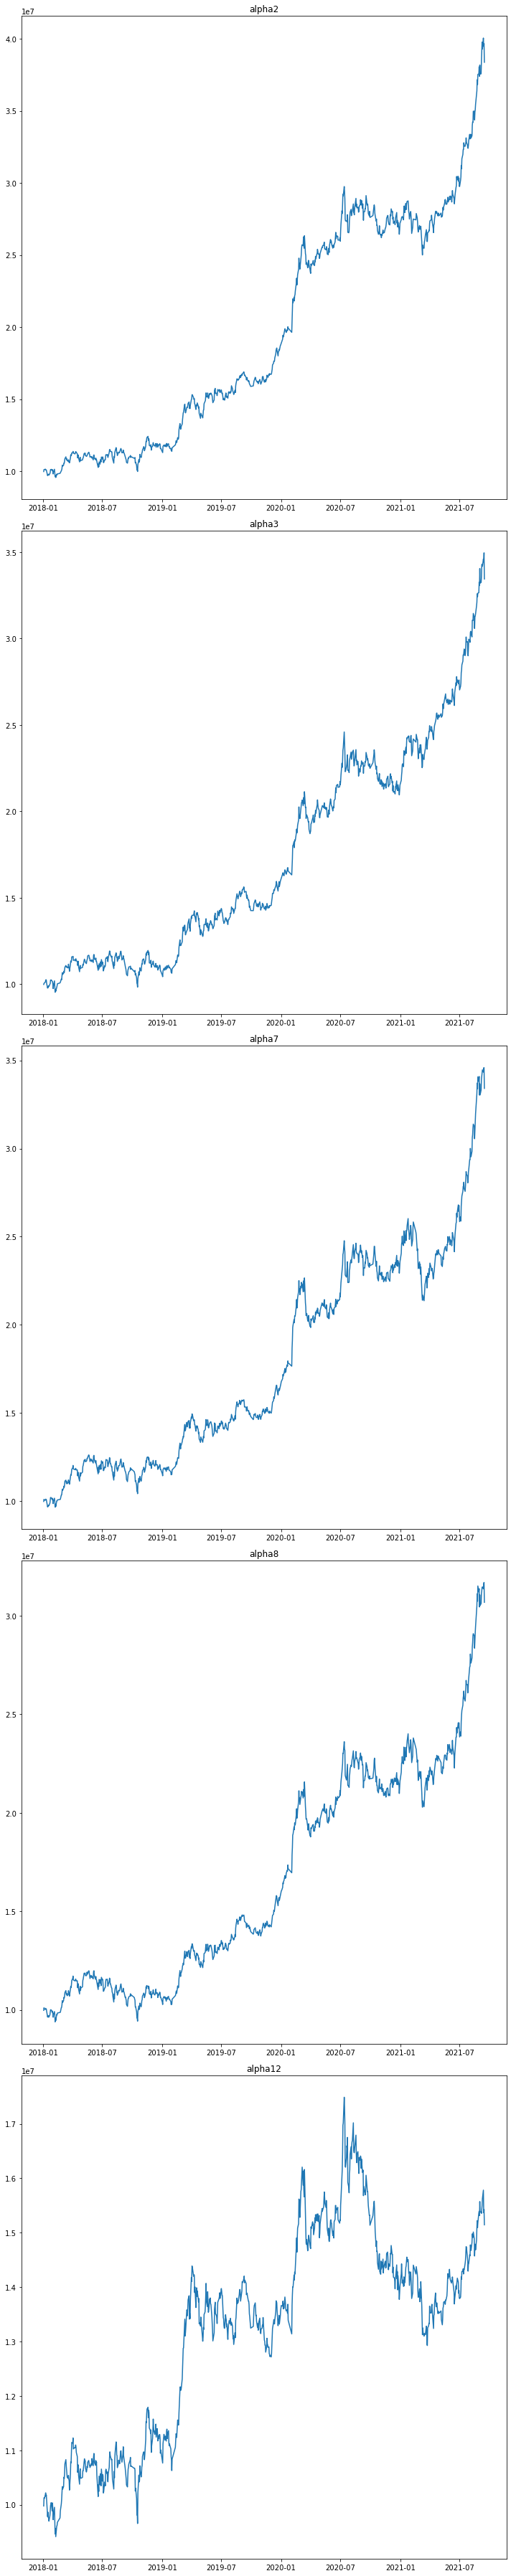

In [383]:
fig, ax = plt.subplots(5, 1, figsize = (10,50))
list1 = [1,2,6,7,11]
for l in range(5):
    k = list1[l]
    money = 10000000
    num = 10
    rate = 0.0015
    pos = []
    index1 = []
    for i in alpha_set[k].index[15:]:
        if i.hour == 15 and i.minute == 0:
            index1.append(i.date())
    portfolio = pd.Series(index = index1)
    df_ret=df2['ret'].copy().fillna(0)
    for i in range(100):
        pos.append(money/100)
    for i in alpha_set[k].index[15:]:
        if i.hour == 15 and i.minute == 0:
            money = 0
            for j in range(100):
                pos[j] = pos[j] * (1 + df_ret.loc[i][j])
                money += abs(pos[j]*(1-rate))
            portfolio.loc[i.date()] = money
        else:
            money = 0
            for j in range(100):
                pos[j] = pos[j] * (1 + df_ret.loc[i][j])
                money += abs(pos[j]*(1-rate))
                pos[j] = 0
        #         portfolio.loc[i] = money
            rank=alpha_set[k].loc[i].dropna().sort_values()
            for j in range(10):
                pos[rank.index[j]]-=money/(2*num)/(1-rate)
            for j in range(1,11):
                pos[rank.index[-j]]=money/(2*num)/(1-rate)
    ax[l].plot(portfolio)
    ax[l].set_title('alpha' + str(k + 1))
    plt.tight_layout()
    print('alpha' + str(k + 1) + ' 最大回撤：', np.min(portfolio / np.maximum.accumulate(portfolio) - 1))
    print('alpha' + str(k + 1) + ' 年化收益率', (portfolio.iloc[-1]/portfolio.iloc[0])**(252/len(portfolio.index))-1)
    print('alpha' + str(k + 1) + ' Sharpe ratio',((portfolio.iloc[-1]/portfolio.iloc[0])**(252/len(portfolio.index))-1)/(portfolio.pct_change().std()* np.sqrt(252)))


Below is equal rights, ICIR and IC weighted synthetic single factor.



In [114]:
IC_roll=[]
for i in range(12):
    IC_roll.append(IC[i].rolling(12).mean())

In [116]:
ICIR_roll=[]
for i in range(12):
    ICIR_roll.append(IC[i].rolling(12).mean()/IC[i].rolling(12).std())

In [196]:
alpha_eq = (alpha_set[1] + alpha_set[2] + alpha_set[6] + alpha_set[7] - alpha_set[11]) / 5
alpha_ic = alpha_eq[0:1]
for i in range(1,alpha_set[1].shape[0]):
    temp = (alpha_set[1][i:i+1]*IC_roll[1].iloc[i-1] + alpha_set[2][i:i+1]*IC_roll[2].iloc[i-1] + alpha_set[6][i:i+1]*IC_roll[6].iloc[i-1] + 
            alpha_set[7][i:i+1]*IC_roll[7].iloc[i-1] + alpha_set[11][i:i+1]*IC_roll[11].iloc[i-1]) / (IC_roll[1].iloc[i-1]+IC_roll[2].iloc[i-1]+IC_roll[6].iloc[i-1]+IC_roll[7].iloc[i-1]-IC_roll[11].iloc[i-1]) 
    alpha_ic = pd.concat([alpha_ic,temp],axis=0)
alpha_icir = alpha_eq[0:1]
for i in range(1,alpha_set[1].shape[0]):
    temp = (alpha_set[1][i:i+1]*ICIR_roll[1].iloc[i-1] + alpha_set[2][i:i+1]*ICIR_roll[2].iloc[i-1] + alpha_set[6][i:i+1]*ICIR_roll[6].iloc[i-1] + 
            alpha_set[7][i:i+1]*ICIR_roll[7].iloc[i-1] + alpha_set[11][i:i+1]*ICIR_roll[11].iloc[i-1]) / (ICIR_roll[1].iloc[i-1]+ICIR_roll[2].iloc[i-1]+ICIR_roll[6].iloc[i-1]+ICIR_roll[7].iloc[i-1]-ICIR_roll[11].iloc[i-1]) 
    alpha_icir = pd.concat([alpha_icir,temp],axis=0)

In [197]:
alpha_ic

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 10:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 11:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 11:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-02 13:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16 11:30:00,-0.365246,-0.048201,-1.301440,0.692049,0.454918,-1.417725,-0.225305,1.649892,0.101752,0.705561,...,-1.311481,-0.223564,0.584924,0.214683,-0.262152,0.035227,-0.016823,-0.310124,0.596849,-0.198295
2021-09-16 13:30:00,0.213956,-1.068636,0.091634,0.114271,0.170139,0.326741,0.199091,-1.845408,-0.306967,-0.375392,...,0.403374,-0.323826,0.128346,0.205870,0.507384,0.444379,0.293222,0.352467,-1.723316,0.107771
2021-09-16 14:00:00,-0.551567,1.150787,-0.946467,0.467681,-0.435396,0.143778,-0.091065,1.521249,-0.410532,0.231299,...,-0.429326,1.002093,0.490263,-0.369469,0.068527,-0.722952,-1.365694,-0.392174,1.026630,-0.539344


The IC calculation of the three synthetic factor below can be seen that the effect of the factors of equivalent synthesis is the best (only the cumulative IC curve of the factors of equivalent synthesis). The following use of equivalent factors to predict the rate of return and construct the strategy.

In [200]:
from sklearn import linear_model
from sklearn.impute import SimpleImputer
reg=linear_model.LinearRegression(fit_intercept=True,normalize=False)
imp=SimpleImputer(np.nan, "mean")
x=alpha_eq.copy().values.reshape(-1,1)
y=df2['ret'].copy().shift(-1).values.reshape(-1,1)
x=imp.fit_transform(x)
y=imp.fit_transform(y)
reg.fit(x,y)
print('reg.coef:', reg.coef_)
print('reg.intercept:', reg.intercept_)
print('reg.score:', reg.score(x,y))

reg.coef: [[0.00036166]]
reg.intercept: [0.00012187]
reg.score: 0.0008644334245555552


The IC curve accumulated IC curve of equivalent synthesis is as follows:

IC of alpha7232 count    7226.000000
mean        0.068476
std         0.142925
min        -0.443620
25%        -0.026605
50%         0.071487
75%         0.166293
max         0.608638
dtype: float64


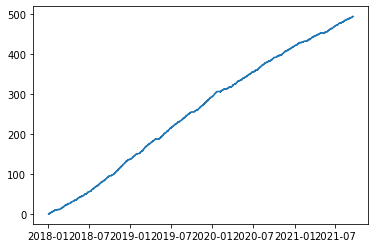

In [371]:
f_ret = df2['ret'].shift(-1)
alpha = alpha_eq
IC1 = []
for i in range(f_ret.shape[0]):
    s1 = alpha.iloc[i].values
    s2 = f_ret.iloc[i].values
    x = pd.DataFrame([s1, s2]).T.corr(method = 'spearman')[0][1]
    IC1.append(x)
ICSeries = pd.Series(IC1, index = f_ret.index)
print('IC of alpha'+str(i + 1), ICSeries.describe())
plt.plot(ICSeries.cumsum())

Finally, we use the following trading strategies: the frequency of adjustment is 30min, and the position is closed during daily closing. Each calculation equivalent is co -forming and sorted, and 10 stocks with the highest sort value.
10 stocks with the lowest sort value, allocated proportion of amounts and other proportions. The recovery fee is calculated at 0.0015.

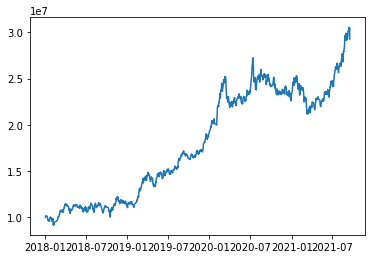

In [361]:
money = 10000000
num = 10
rate = 0.0015
pos = []
index1 = []
for i in alpha_eq.index[15:]:
    if i.hour == 15 and i.minute == 0:
        index1.append(i.date())
portfolio = pd.Series(index = index1)
df_ret=df2['ret'].copy().fillna(0)
for i in range(100):
    pos.append(money/100)
for i in alpha_eq.index[15:]:
    if i.hour == 15 and i.minute == 0:
        money = 0
        for j in range(100):
            pos[j] = pos[j] * (1 + df_ret.loc[i][j])
            money += abs(pos[j]*(1-rate))
        portfolio.loc[i.date()] = money
    else:
        money = 0
        for j in range(100):
            pos[j] = pos[j] * (1 + df_ret.loc[i][j])
            money += abs(pos[j]*(1-rate))
            pos[j] = 0
#         portfolio.loc[i] = money
        rank=alpha_eq.loc[i].dropna().sort_values()
        for j in range(10):
            pos[rank.index[j]]-=money/(2*num)/(1-rate)
        for j in range(1,11):
            pos[rank.index[-j]]=money/(2*num)/(1-rate)
plt.clf()
plt.plot(portfolio)
portfolio = portfolio.fillna(0)


In [2]:
day = (portfolio.index[-1] - portfolio.index[15]).days
print('max drawdown：', np.min(portfolio / np.maximum.accumulate(portfolio) - 1))
print('annual return', (portfolio.iloc[-1]/portfolio.iloc[0])**(252/len(portfolio.index))-1)
print('Sharpe ratio',((portfolio.iloc[-1]/portfolio.iloc[0])**(252/len(portfolio.index))-1)/(portfolio.pct_change().std()* np.sqrt(252)))

max drawdown： -0.2231745677095246
annual return 0.3505444889889868
Sharpe ratio 1.5457724302926257
